In [92]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#-------------------Inputs-------------------------------------------------------------
script = "Longitudinal Analysis_2 Paddler.ipynb"
input_file = "Station Information.csv"
outerHull_file = "Outer Hull.csv" # Will be used for hydrostatic force and waterline calculation
DLF = 1.25 # Dead Load Factor
LLF = 1.3 # Live Load Factor
pad_male = 81.64 # Weight of male padder (kg)
pad_female = 57.78 # Weight of female paddler (kg)
water_density = 1000 # Density of water = 1000 kg/m^3
#--------------------------------------------------------------------------------------
pad1_pos = 1489 # Position of first paddler with respect to left end of canoe (mm)
pad2_pos = 4258 # Position of second paddler with respect to left end of canoe (mm)
# Choose between pad_male and pad_female
pad_first = pad_male
pad_second = pad_male
# Apply the Live Load Factor (constant)
pad1 = pad_first * LLF
pad2 = pad_second * LLF
#--------------------------------------------------------------------------------------

script_dir = os.path.abspath('') # absolute file path in Jupyter
file_path = os.path.join(script_dir, input_file) # file path for the station information

# Get the canoe's volume and mass from the station info
canoe_info = pd.read_csv(file_path, header=None)
statVol = canoe_info[1][1:]
statMass = canoe_info[2]

# Get the outer hull coordinates from the input file
file_path = os.path.join(script_dir, outerHull_file)
out_coor = pd.read_csv(file_path, header=None)
x_out = out_coor[0]
y_out = out_coor[1]
z_out = out_coor[2]

# Convert Series to List
stat_Mass = []
for i in range(1,len(statMass),1):
    stat_Mass.append(float(statMass[i]))

stat_Vol = []
for i in range(1,len(statVol),1):
    stat_Vol.append(float(statVol[i]))

canoe_volume = np.sum(stat_Vol) # m^3
canoe_weight = np.sum(stat_Mass)*DLF # [kg]
total_weight = canoe_weight + pad1 + pad2 # [kg]

station_no = x_out.nunique() # number of stations
station = x_out.unique() # location of each station

In [93]:
# Outer Hull Volume
vol_out = []

# Loop through each station
# The loop ends at station_no - 2 because each loop uses the kth and the (k+1)th station
# Starts at 1 to skip 0,0,0
for k in range(1,station_no-2,1):

    # Coordinates of points in the outer frame sharing an X-coordinate with the current station
    X1_value = station[k]
    Y1 = []
    Z1 = []

    # Coordinates of points in the outer frame sharing an X-coordinate with the next station
    X2_value = station[k+1]
    Y2 = []
    Z2 = []

    # Loop through each x coordinate in the outer hull
    for i in range(0,len(x_out),1):

        # If the coordinate is aligned with the second station on the X-axis, store this XYZ coordinate
        if x_out[i] == X1_value:
            Y1.append(y_out[i])
            Z1.append(z_out[i])

        # Otherwise, if the coordinate is aligned with the second station on the X-axis, store this XYZ coordinate
        elif x_out[i] == X2_value:
            Y2.append(y_out[i])
            Z2.append(z_out[i])
    

    # NOTE: Problem Loop
    volume = 0
    # Code appears to be irrelevant
    """
    if len(Y1)/2 == 0:
        n = int(len(Y1)/2)
        for j in range(0,n,1):
            area1 = (abs(Y1[j])+abs(Y1[j+1]))*abs(Z1[j]-Z1[j+1])/2*2
            area2 = (abs(Y2[j])+abs(Y2[j+1]))*abs(Z2[j]-Z2[j+1])/2*2
            volume = volume + abs(X1_value - X2_value)*(area1 + area2)/2
    else:
    """

    # Only perform ___ if there is a point on the currently 
    # NOTE: Explain loop, only loops through half of the points found? <?>
    if len(Y1) > 0:
        n = int((len(Y1)-1)/2)
        for j in range(0,n,1):
            area1 = (abs(Y1[j])+abs(Y1[j+1]))*abs(Z1[j]-Z1[j+1])/2*2
            area2 = (abs(Y2[j])+abs(Y2[j+1]))*abs(Z2[j]-Z2[j+1])/2*2
            volume = volume + abs(X1_value - X2_value)*(area1 + area2)/2
        # triangle piece at the bottom
        area1 = abs(Y1[n-1])*abs(Z1[n-1])/2*2
        area2 = abs(Y2[n-1])*abs(Z2[n-1])/2*2
        volume = volume + abs(X1_value - X2_value)*(area1 + area2)/2
        vol_out.append(volume)

outer_volume = np.sum(vol_out)/10**9 #[m^3]

In [94]:
# Acquire the waterline from Grasshopper
grasshopper = 164 # [mm]
canoe_depth = max(abs(z_out)) 
waterline = canoe_depth - grasshopper # distance from the water surface to the bottom of canoe [mm]
increment = 3 # push down waterline by [] mm
water_weight = outer_volume*water_density # Assume canoe is fully submerged in water

#while water_weight - total_weight < 10:
# NOTE: Problem Loop (identical for no good reason?)
vol_out = []
for k in range(1,station_no-2,1):
    X1_value = station[k]
    X2_value = station[k+1]
    Y1 = []
    Y2 = []
    Z1 = []
    Z2 = []


    for i in range(0,len(x_out),1):
        if canoe_depth - abs(z_out[i]) <= waterline:
            if x_out[i] == X1_value:
                Y1.append(y_out[i])
                Z1.append(z_out[i])

            elif x_out[i] == X2_value:
                Y2.append(y_out[i])
                Z2.append(z_out[i])

    volume = 0
    if len(Y1)/2 == 0:
        n = int(len(Y1)/2)
        for j in range(0,n,1):
            area1 = (abs(Y1[j])+abs(Y1[j+1]))*abs(Z1[j]-Z1[j+1])/2*2
            area2 = (abs(Y2[j])+abs(Y2[j+1]))*abs(Z2[j]-Z2[j+1])/2*2
            volume = volume + abs(X1_value - X2_value)*(area1 + area2)/2
    else:
        n = int((len(Y1)-1)/2)
        for j in range(0,n,1):
            area1 = (abs(Y1[j])+abs(Y1[j+1]))*abs(Z1[j]-Z1[j+1])/2*2
            area2 = (abs(Y2[j])+abs(Y2[j+1]))*abs(Z2[j]-Z2[j+1])/2*2
            volume = volume + abs(X1_value - X2_value)*(area1 + area2)/2
        # triangle piece at the bottom
        area1 = abs(Y1[n-1])*abs(Z1[n-1])/2*2
        area2 = abs(Y2[n-1])*abs(Z2[n-1])/2*2
        volume = volume + abs(X1_value - X2_value)*(area1 + area2)/2
        vol_out.append(volume)


# Volumes of decks
X1_value = station[0]
X2_value = station[0+1]
Y1 = []
Y2 = []
Z1 = []
Z2 = []

for i in range(0,len(x_out),1):
    if x_out[i] == X1_value:
        Y1.append(y_out[i])
        Z1.append(z_out[i])

    if canoe_depth - abs(z_out[i]) <= waterline:
        if x_out[i] == X2_value:
            Y2.append(y_out[i])
            Z2.append(z_out[i])

l = abs(max(Y2)-min(Y2))
w = abs(max(Z2)-min(Z2))
h = abs(X2_value - X1_value)
volume = l*w*h/3
vol_out.insert(0, volume)

X1_value = station[len(station)-1]
X2_value = station[len(station)-2]
Y1 = []
Y2 = []
Z1 = []
Z2 = []

for i in range(0,len(x_out),1):
    if x_out[i] == X1_value:
        Y1.append(y_out[i])
        Z1.append(z_out[i])

    if canoe_depth - abs(z_out[i]) <= waterline:
        if x_out[i] == X2_value:
            Y2.append(y_out[i])
            Z2.append(z_out[i])

l = abs(max(Y2)-min(Y2))
w = abs(max(Z2)-min(Z2))
h = abs(X2_value - X1_value)
volume = l*w*h/3
vol_out.append(volume)

water_volume = np.sum(vol_out)/10**9 #[m^3]
water_weight = water_volume*water_density

waterline = waterline - increment

print('The depth of water is ', waterline, ' mm.')
print('The waterline is at', canoe_depth-waterline, 'mm.')
print('The weight of water is ', water_weight, 'kg.')
print('The total weight is ', total_weight, 'kg.')

The depth of water is  175.5  mm.
The waterline is at 167.0 mm.
The weight of water is  357.09309041914617 kg.
The total weight is  399.27605159307205 kg.


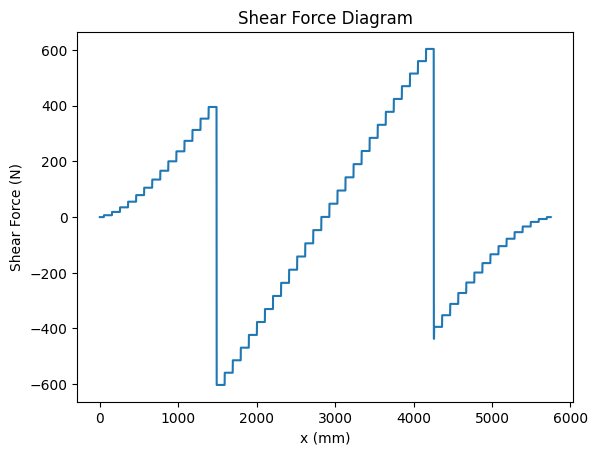

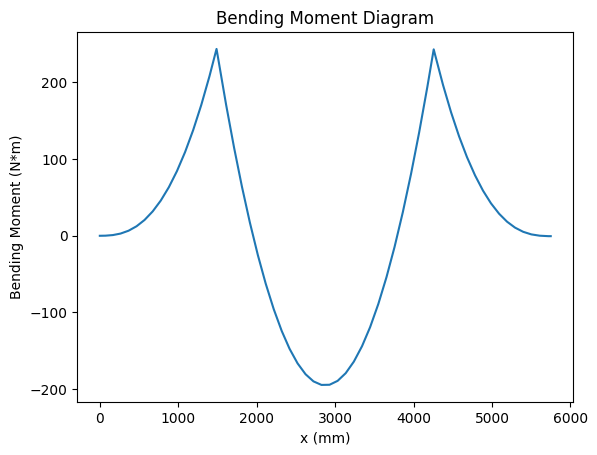

Maximum shear is  604.0540282540019 N.
Maximum moment is  243.65822125004613 Nm.


In [95]:
difference = water_weight - total_weight
vol_mass = []

for i in range(0,len(vol_out),1):
    mass = (vol_out[i]/10**9)*water_density - difference/len(vol_out)
    vol_mass.append(mass)
    
# Plot SFD and BMD
pad_weight = [pad1, pad2]

length = max(x_out)
pad_pos = [pad1_pos, pad2_pos]

stat_x = []
for i in range(0,len(station)-1,1):
    stat_x.append((station[i]+station[i+1])/2)

g = 9.81
x = []
shear = []
for i in range(0,int(length),1):
    x.append(i)
    shear_force = 0
    for j in range(0,len(stat_x),1):
        if i >= stat_x[j]:
            shear_force  = shear_force + vol_mass[j]*g +(-1)*stat_Mass[j]*g*DLF
        else:
            shear_force = shear_force
    for k in range(0,len(pad_pos),1):
        if i >= pad_pos[k]:
            shear_force = shear_force - pad_weight[k]*g
        else:
            shear_force = shear_force
    shear.append(shear_force)

plt.plot(x,shear)
plt.title('Shear Force Diagram')
plt.xlabel('x (mm)')
plt.ylabel('Shear Force (N)')
plt.show()


# Export points to csv file:
df1 = pd.DataFrame(data={'Length': x, 'Shear': shear})

csv_file = 'Length_vs_Shear_2 Paddler.csv'
script_dir = os.path.abspath('')
file_path = os.path.join(script_dir, csv_file)
df1.to_csv(file_path, index=False)

moment = []
moment.append(0)
bending_moment = 0
for i in range(1,len(x),1):
    bending_moment = bending_moment + (x[i]-x[i-1])*shear[i]/1000
    moment.append(bending_moment)

plt.plot(x,moment)
plt.title('Bending Moment Diagram')
plt.xlabel('x (mm)')
plt.ylabel('Bending Moment (N*m)')
plt.show()


# Export points to csv file:
df1 = pd.DataFrame(data={'Length': x, 'Moment': moment})

csv_file = 'Length_vs_Moment_2 Paddler.csv'
script_dir = os.path.abspath('')
file_path = os.path.join(script_dir, csv_file)
df1.to_csv(file_path, index=False)



max_shear = max(abs(min(shear)), abs(max(shear)))
max_moment = max(abs(min(moment)), abs(max(moment)))

print('Maximum shear is ', max_shear, 'N.')
print('Maximum moment is ', max_moment, 'Nm.')

In [96]:
# export the values to csv file
titles = ['Positive Shear [N]', 'Negative Shear [N]', 'Positive Bending Moment [Nm]', 'Negative Bending Moment [Nm]', 'Moment at the end [Nm]']
values = [max(shear), min(shear), max(moment), min(moment), moment[len(moment)-1]]
station_no = []
max_width = []
max_depth = []

for value in [max(shear), min(shear)]:
    shear_index = shear.index(value)
    xshear = x[shear_index]
    for i in range(0,len(station)-1,1):
        if (xshear >= station[i] and xshear < station[i+1]):
            station_index = i+1

    X1_value = station[station_index-1]
    X2_value = station[station_index]
    Y1 = []
    Y2 = []
    Z1 = []
    Z2 = []        
    for i in range(0,len(y_out),1):
        if x_out[i] == X1_value:
            Y1.append(y_out[i])
            Z1.append(z_out[i])
        elif x_out[i] == X2_value:
            Y2.append(y_out[i])
            Z2.append(z_out[i])
    width = (max(Y1)-min(Y1)+max(Y2)-min(Y2))/2
    depth = (abs(min(Z1))+abs(min(Z2)))/2
    max_width.append(width)
    max_depth.append(depth)
    station_no.append(station_index)

for value in [max(moment), min(moment)]:
    moment_index = moment.index(value)
    xmoment = x[moment_index]
    for i in range(0,len(station)-1,1):
        if (xmoment >= station[i] and xmoment < station[i+1]):
            station_index = i+1

    X1_value = station[station_index-1]
    X2_value = station[station_index]
    Y1 = []
    Y2 = []
    Z1 = []
    Z2 = []        
    for i in range(0,len(y_out),1):
        if x_out[i] == X1_value:
            Y1.append(y_out[i])
            Z1.append(z_out[i])
        elif x_out[i] == X2_value:
            Y2.append(y_out[i])
            Z2.append(z_out[i])
    width = (max(Y1)-min(Y1)+max(Y2)-min(Y2))/2
    depth = (abs(min(Z1))+abs(min(Z2)))/2
    max_width.append(width)
    max_depth.append(depth)
    station_no.append(station_index)
    
station_no.append(len(station)-1)  
max_width.append('')
max_depth.append('')

df1 = pd.DataFrame(data={'': titles, 'Value': values, 'Station No': station_no, 'Max Width [mm]': max_width, 'Max Depth [mm]': max_depth})

csv_file = 'Shear_and_Moment_2 Paddlers.csv'
script_dir = os.path.abspath('')
file_path = os.path.join(script_dir, csv_file)
df1.to_csv(file_path, index=False)


In [97]:
# Make a CSV file for buoyancy and gravity
# vol_mass (Array of force_buoyancy by station)
# stat_mass (Array of force_gravity by station)
df1 = pd.DataFrame(data={'Station No.': range(1, len(vol_mass) + 1, 1), 'Buoyancy Force [N]': [i * g for i in vol_mass], 'Applied Force [N]': [i * g for i in stat_Mass] })

csv_file = 'Station_Loads_2 Paddlers.csv'
script_dir = os.path.abspath('')
file_path = os.path.join(script_dir, csv_file)
df1.to_csv(file_path, index=False)
print("Complete !")

Complete !


# 

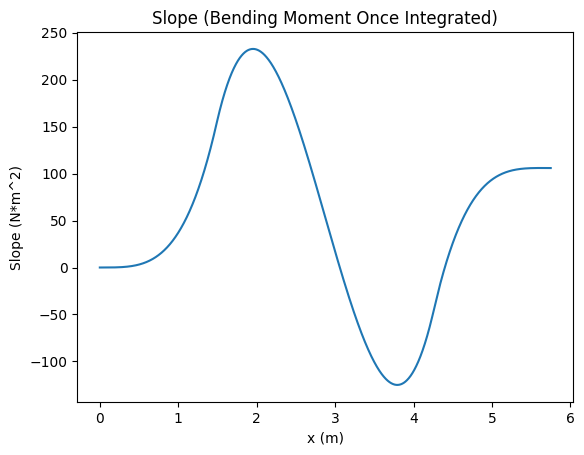

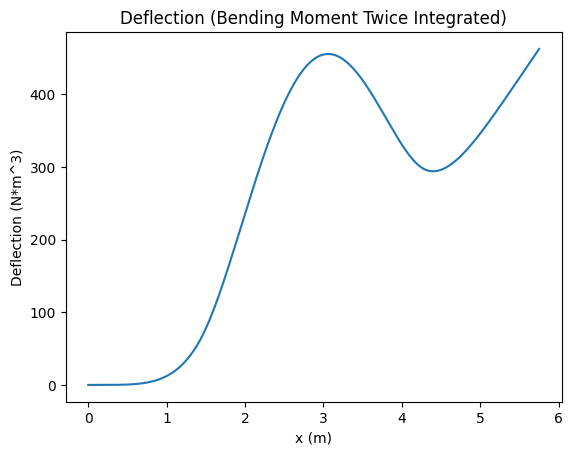

In [98]:
# Deflection for now <?>

# Convert x to m
x = [i / 1000 for i in x]

# Integrate a matplotlib graph
# xList and yList are from matplotlib graph
# C is the integration constant
def integrate(yList, xList, C):
    # The function starts at C
    output = [C]
    for i in range(len(xList) - 1):
        riemannHeight = yList[i+1] + yList[i] / 2
        riemannWidth = xList[i+1] - xList[i]
        output.append(output[i] + (riemannHeight * riemannWidth))
    return output


# Integrate to find slope
slope = integrate(moment, x, 0)

# Plot slope
plt.plot(x,slope)
plt.title("Slope (Bending Moment Once Integrated)")
plt.xlabel('x (m)')
plt.ylabel('Slope (N*m^2)')
plt.show()

# Integrate to find deflection
deflection = integrate(slope, x, 0)

# Plot Deflection
plt.plot(x,deflection)
plt.title("Deflection (Bending Moment Twice Integrated)")
plt.xlabel('x (m)')
plt.ylabel('Deflection (N*m^3)')
plt.show()
